# Introduction to the General Linear Model

*Written by Luke Chang*

This tutorial provides an introduction for how the general linear model (GLM) can be used to make inferences about brain responses in a single subject. We will explore the statistics in the context of a simple hypothetical experiment using simulated data. 

In this lab we will cover:
- How to use a GLM to test psychological hypotheses.
- Simulating brain data
- Estimating GLM using ordinary least squares
- Calculating Standard Errors
- Contrast Basics

Let's start by watching two short videos introducing the general linear model by Tor Wager and how this can be applied to fMRI.

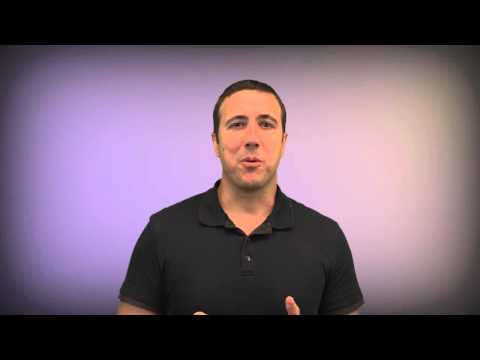

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('GDkLQuV4he4')

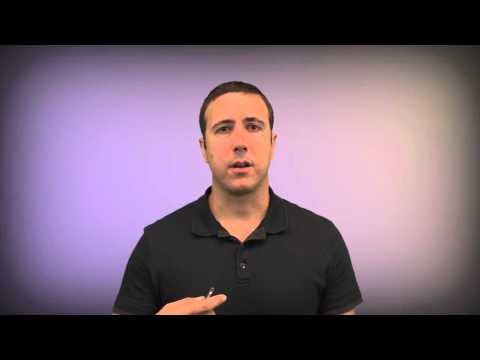

In [2]:
YouTubeVideo('OyLKMb9FNhg')

## Are you ready for this?
This lab assumes that you have some basic background knowledge in statistics from an introductory course. If you are already feeling overwhelmed from Tor Wager's videos and think you might need to slow down and refresh some basic concepts and lingo, I highly encourage you to watch Jeannette Mumford's crash course in statistics. These are certainly not required, but she is a wonderful teacher and watching her videos will provide an additional explanation of the core concepts needed to understand the GLM. You could watch these in one sitting, or go back and forth with working through the notebooks. There is so much to know in statistics and people can often feel lost because the concepts are certainly not intuitive. For example, even though advanced statistics have been an important part of my own work, I still find it helpful to periodically revisit core concepts. In general, I find that learning neuroimaging is an iterative process. In the beginning, it is important to get a broad understanding of the key steps and how neuroimaging can be used to make inferences, but as you progress in your training you will have plenty of opportunities to zoom into specific steps to learn more about particular details and nuances that you may not have fully appreciated the first time around.  
- [Basic statistics terminology](https://youtu.be/apt8uAgtgdY) This video gently introduces some of the key concepts that provide the foundation for statistics.
- [Simple Linear Regression](https://www.youtube.com/watch?v=yLgPpmXVVbs) This video explains how a regression works using a single variable.
- [Matrix Algebra Basics](https://www.youtube.com/watch?v=fkZj8QoYjq8) This video provides the background linear algebra needed for understanding the GLM.
- [Multiple Linear Regression](https://www.youtube.com/watch?v=qdOG7YMolmA) This video explains how multiple regression works using linear algebra.
- [Hypothesis Testing](https://www.youtube.com/watch?v=ULeg3DH3g9w) This video covers the basics of hypothesis testing.
- [Contrasts in Linear Models](https://www.youtube.com/watch?v=yLgPpmXVVbs&t=631s) This video provides an overview of how to test hypotheses using contrasts in the context of the GLM.
- [Intepreting Regression Parameters](https://www.youtube.com/watch?v=uClfe4pLrCo) This video covers how to interpret the results from a regression analysis.
- [Mean Centering Regressors](https://www.youtube.com/watch?v=K4S576j90N8) This video covers a more subtle detail of why you might consider mean centering your continuour regression variables.


Ok, let's get started. First, we will need to import all of the modules used in this tutorial.

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
from nltools.external import glover_hrf

## Simulate a voxel time course
To generate an intuition for how we use the GLM to make inferences in fMRI data analysis, we will simulate a time series for a single voxel. A simulation means that we will be generating synthetic data that will resemble real data. However, because we know the ground truth of the signal, we can evaluate how well we can recover the true signal using a general linear model. Throughout this course, we frequently rely on simulations to gain an intuition for how a particular preprocessing step or statistic works. This is important because it reinforces the assumptions behind the operation (which are rarely met in real data), and also provides a method to learn how to answer your own questions by generating your own simulations.

Imagine that we are interested in identifying which region of the brain is involved in processing faces. To explore this question, we could show participants a bunch of different types of faces. Each presentation of a face will be a *trial*. Let's simulate what a design might look like with 5 face trials.

First, we will need to specify the number of volumes in the time series. Then we need to specify the timepoint, in which a face is presented.

![faces](../images/glm/faces.png)

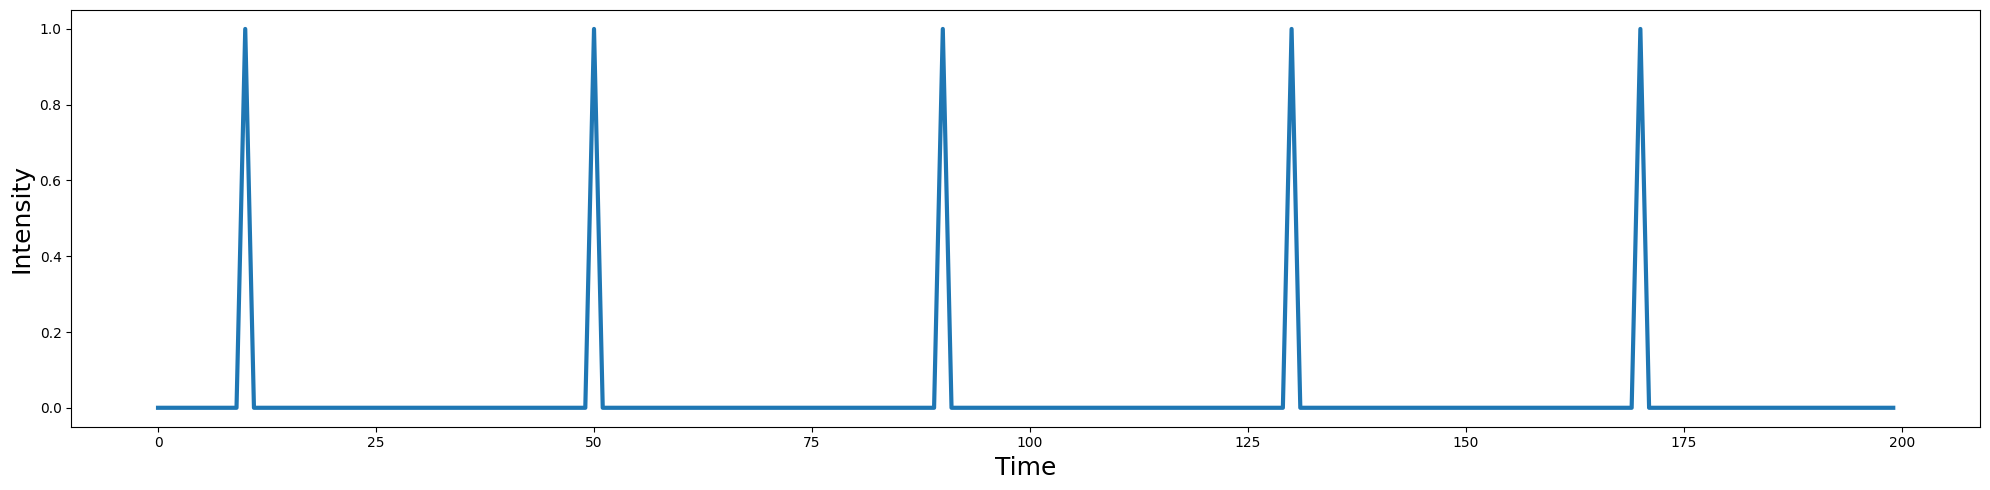

In [2]:
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1

def plot_timeseries(data, labels=None, linewidth=3):
    '''Plot a timeseries
    
    Args:
        data: (np.ndarray) signal varying over time, where each column is a different signal.
        labels: (list) labels which need to correspond to the number of columns.
        linewidth: (int) thickness of line
    '''
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        if len(labels) != data.shape[1]:
            raise ValueError('Need to have the same number of labels as columns in data.')
        plt.legend(labels, fontsize=18)
    
plot_timeseries(face)

We now have 5 events where a face is shown for 2 seconds (i.e., one TR). If we scanned someone with this design, we might expect to see any region involved in processing faces increase in activation around the time of the face presentation. How would we know which of these regions, if any, *selectively* process faces? Many of the regions we would observe are likely involved in processing *any* visual stimulus, and not specifically faces.

To rule out this potential confound, we would need at least one other condition that would serve as a visual control. Something that might have similar properties to a face, but isn't a face. 

One possibility is to create a visual stimulus that has all of the same visual properties in terms of luminance and color, but no longer resembles a face. Here is an example of the same faces that have been Fourier transformed, phase-scrambled, and inverse Fourier transformed. These pictures have essentially identical low level visual properties, but are clearly not faces.

![phase](../images/glm/phase_scrambled.png)

However, one might argue that faces are a type of object, and regions that are involved in higher visual processing such as object recognition might not be selective to processing faces. To rule out this possibility, we would need to add an additional visual control such as objects.

![objects](../images/glm/objects.png)

Both of these conditions could serve as a different type of visual control. To keep things simple, let's start with pictures of objects as it controls for low level visual features, but also more complex object processing. 

To demonstrate that a region is processing faces and not simply lower level visual properties or objects more generally, we can search for regions that are selectively more activated in response to viewing faces relative to objects. This is called a *contrast* and is the basic principle of the subtraction method for controlling for potential experimental confounds. Because BOLD fMRI is a relative and not absolute measure of brain activity, the subtraction method is a key aspect of experimental design.

Figures are from Huettel, Song, & McCarthy (2008)

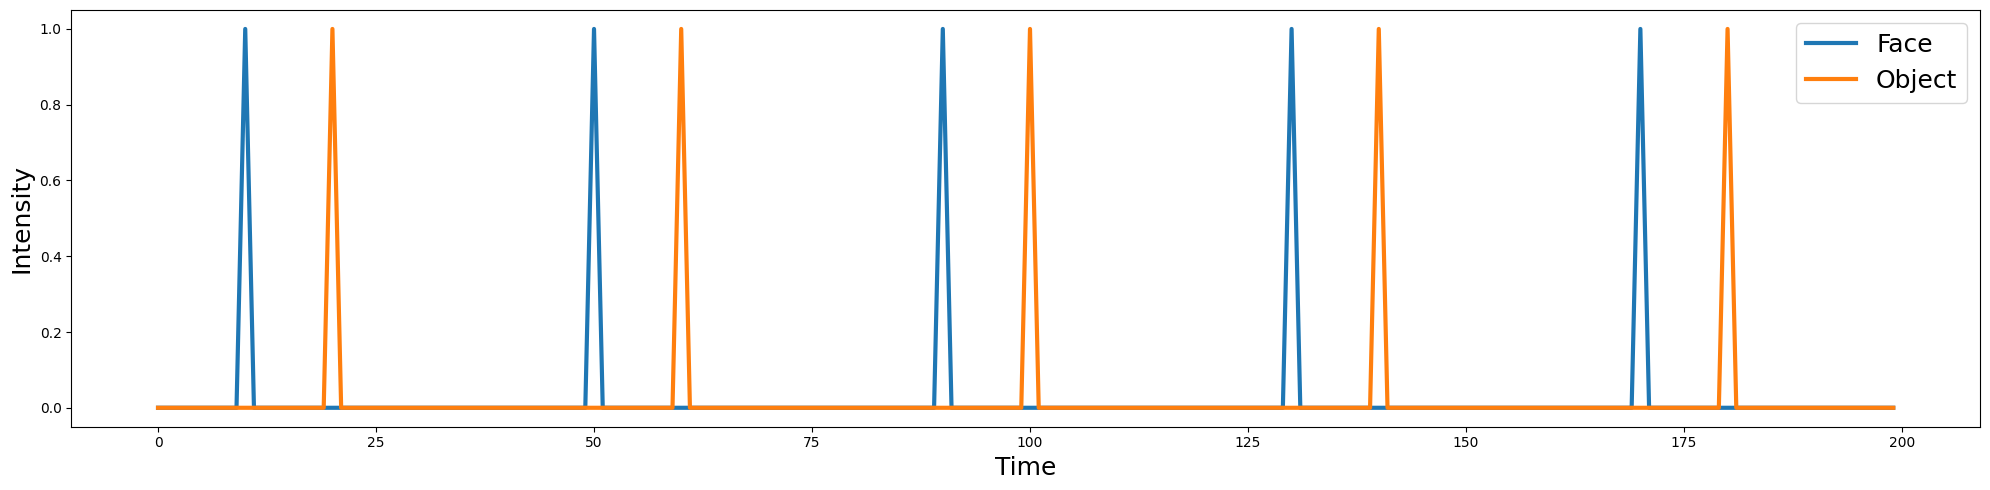

In [3]:
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])

Let's imagine that in a voxel processing face specific information we might expect to see a larger activation in response to faces. Maybe two times bigger?

In our simulation, these two values are parameters we are specifying to generate the data. Specifically they refer to the amplitude of the response to Faces and Houses within a particular region of the brain.

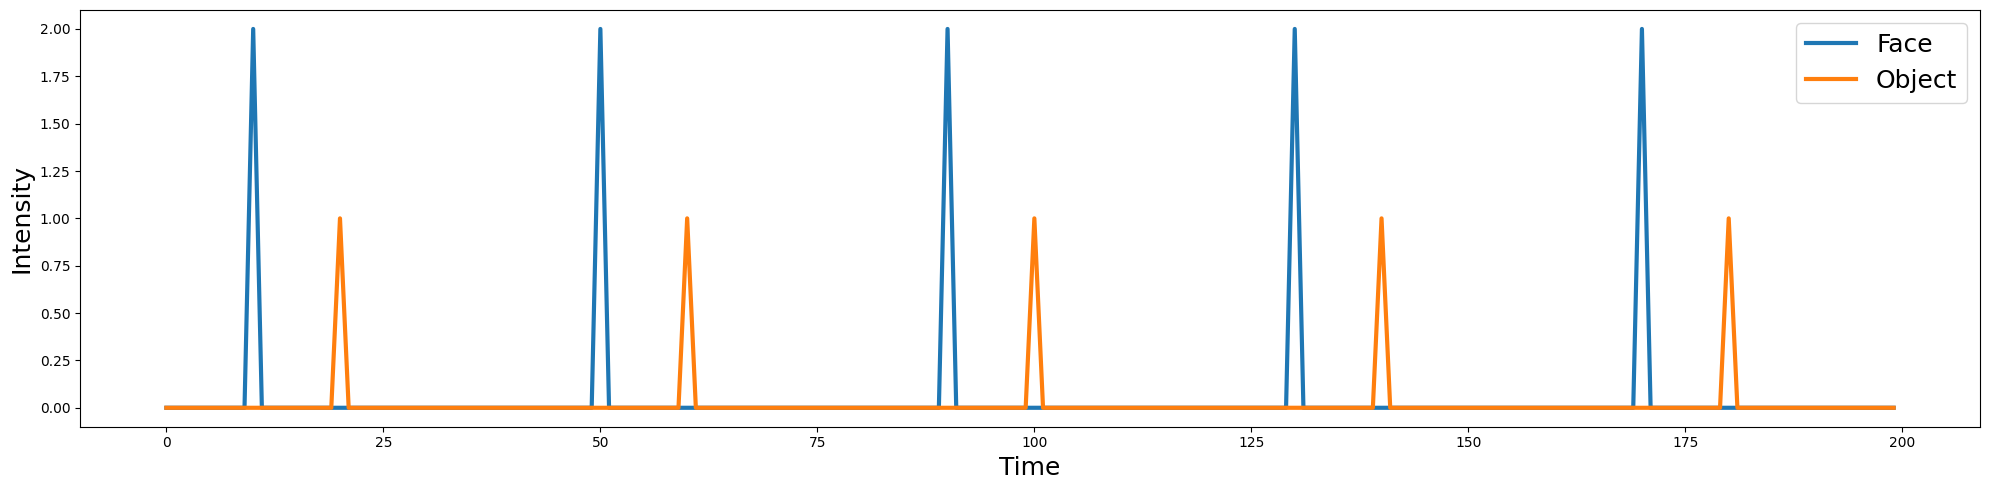

In [4]:
n_tr = 200
n_trial = 5
face_intensity = 2
object_intensity = 1

face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_intensity
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = object_intensity
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])

Ok, now we have two conditions that are alternating over time. 

We know that the brain has a delayed hemodynamic response to events that has a particular shape, so we will need to convolve these events with an appropriate HRF function. Here, we will use the double-gamma HRF function.

Text(0.5, 0, 'Time')

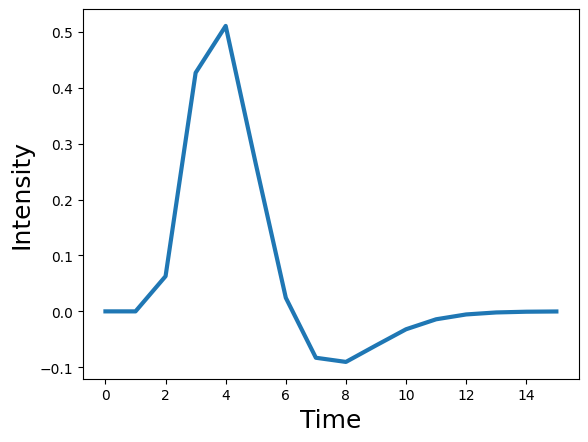

In [5]:
tr = 2
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

We will use `np.convolve` from numpy to perform the convolution.  The length of the convolved data will be the length of the time series plus the length of the kernel minus 1. To make sure everything is the same length, we will chop off the extra time off the convolved time series using `mode='same'`.

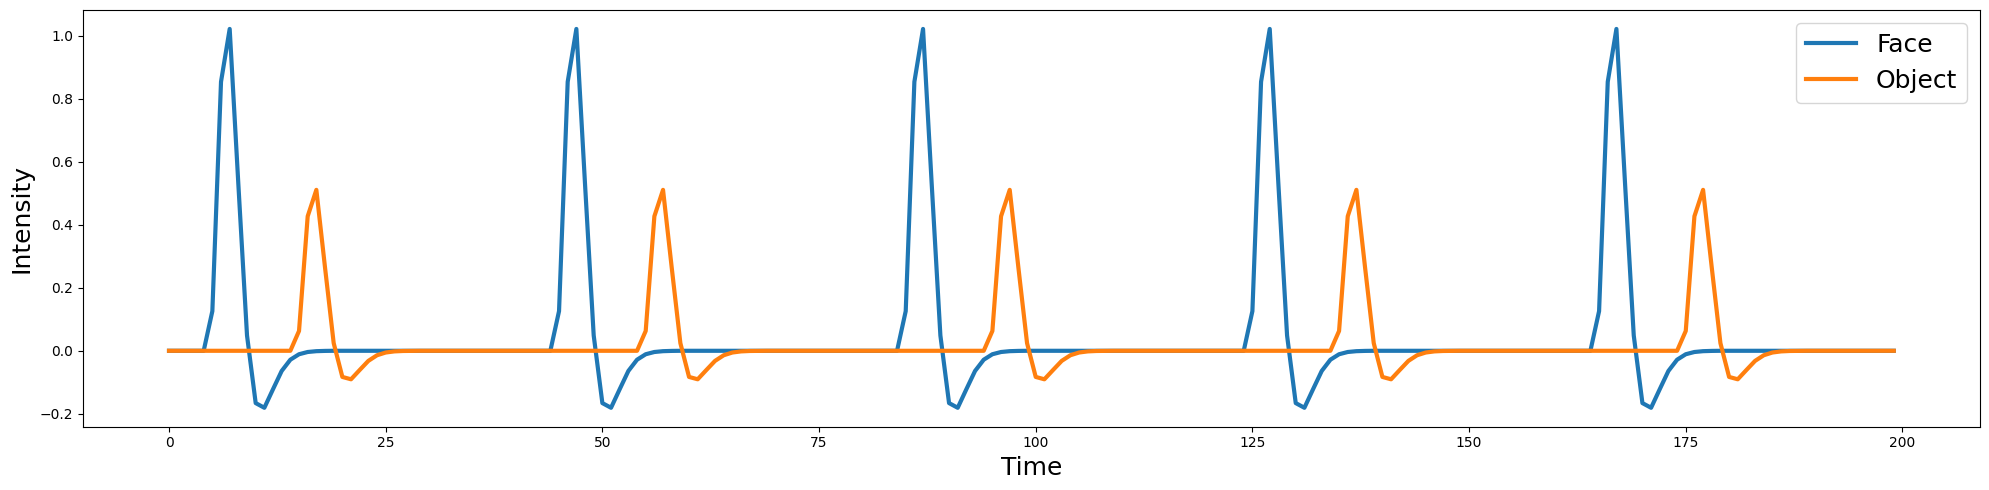

In [6]:
face_conv = np.convolve(face, hrf, mode='same')
obj_conv = np.convolve(obj, hrf, mode='same')
voxel_conv = np.vstack([face_conv, obj_conv]).T

plot_timeseries(voxel_conv, labels=['Face', 'Object'])

While this might reflect the expected HRF response to a single event, real data is much noiser. It is easy to add different types of noise. For example, there might be a low frequency drift, autocorrelation, or possibly some aliased physiological artifacts.

For now, let's start with something simple, like independent white noise drawn from a random Gaussian distribution

$$\epsilon \sim \mathcal{N}(\mu,\,\sigma^{2})$$ 

where $\mu = 0$ and $\sigma = 0.15$

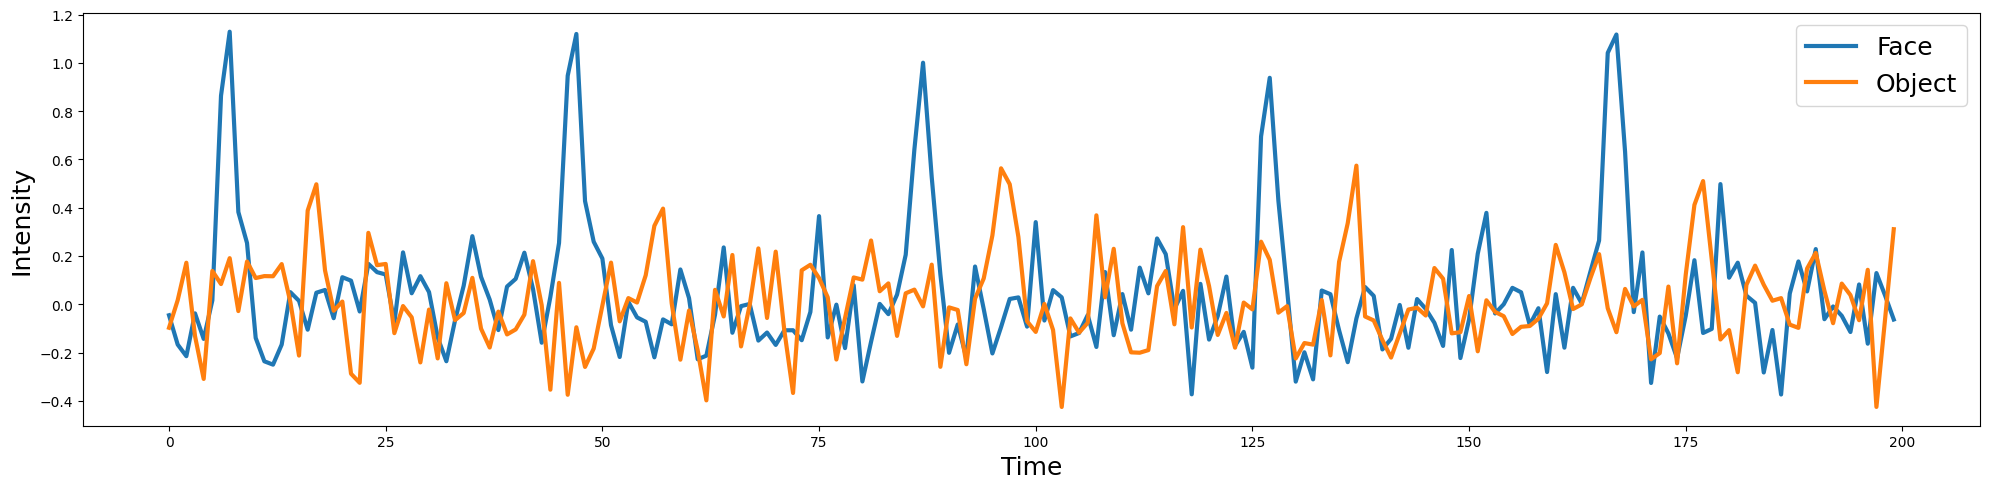

In [7]:
sigma = 0.15
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

plot_timeseries(voxel_conv_noise, labels=['Face', 'Object'])

Now this is looking much more like real BOLD activity.

Remember, the goal of this exercise is to generate simulated activity from a voxel. If we were to extract signal from a specific voxel we wouldn't know which condition was which, so let's combine these two signals into a single simulated voxel timeseries by adding the two vectors together with the `.sum()` method.

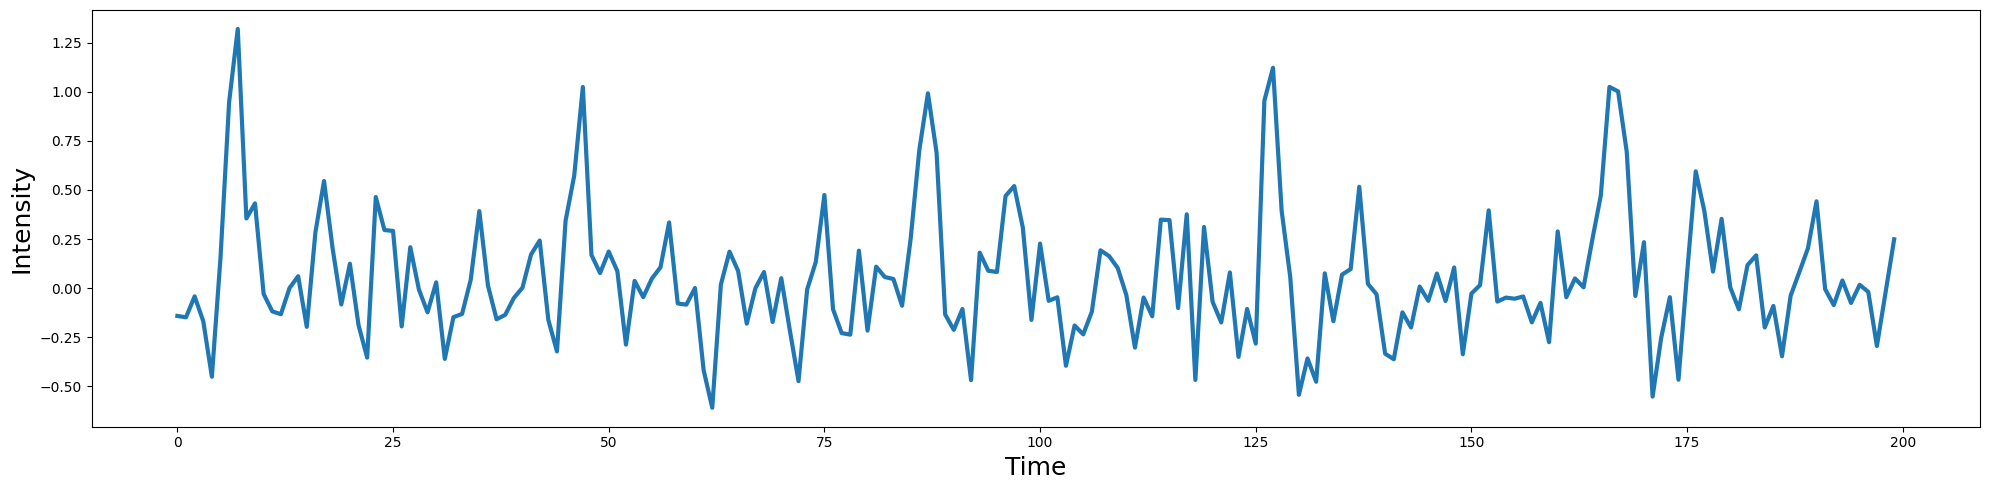

In [8]:
Y = voxel_conv_noise.sum(axis=1)

plot_timeseries(Y)

## Construct Design Matrix

Now that we have our simulated voxel timeseries, let's try and see if we can recover the original signal using a general linear model in the form of:

$$Y = X\beta + \epsilon$$

where $Y$ is our observed voxel time series. $X$ is our model or design matrix, and is where we will specify a predicted response to each condition. $\beta$ is a vector of values that we will estimate to scale our model. $\epsilon$ is independent gaussian noise. This model is linear because we can decompose $Y$ into a set of features or independent variables that are scaled by an estimated $\beta$ parameter and summed together. The $\epsilon$ parameter is not usually known and can also be estimated.

You may be wondering how our model is distinct from our simulated data. Remember when we simulated the data we specified 3 parameters - face amplitude, object amplitude, and $\epsilon$, we could have also added a mean, but for now, let's just assume that it is zero. When we fit our model to the simulated data, we should in theory be able to almost perfectly recover these three parameters.

Now let's build a design matrix $X$ using an intercept, and a regressor indicating the onset of each condition, convolved with the hemodynamic response function (HRF).

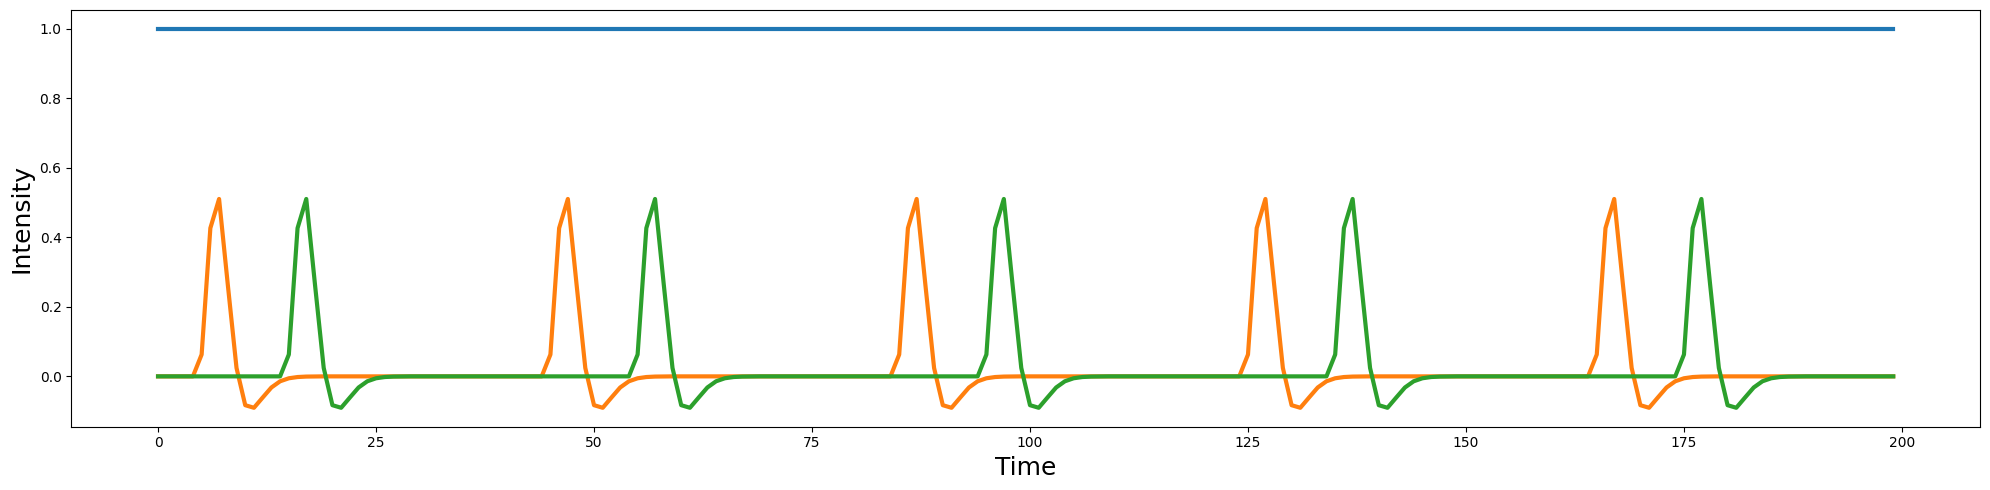

In [10]:
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
intercept = np.ones(n_tr)
X = np.vstack([intercept, np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

plot_timeseries(X)

We can write our model out so that it is very clear what we are doing.

$$Voxel = \beta_0 \cdot Intercept + \beta_1 \cdot Faces + \beta_2 \cdot Objects + \epsilon$$

We can also make a plot and rotate the timeseries, to better reflect the equation.

It should be clear how each of these components relate to the regression equation.

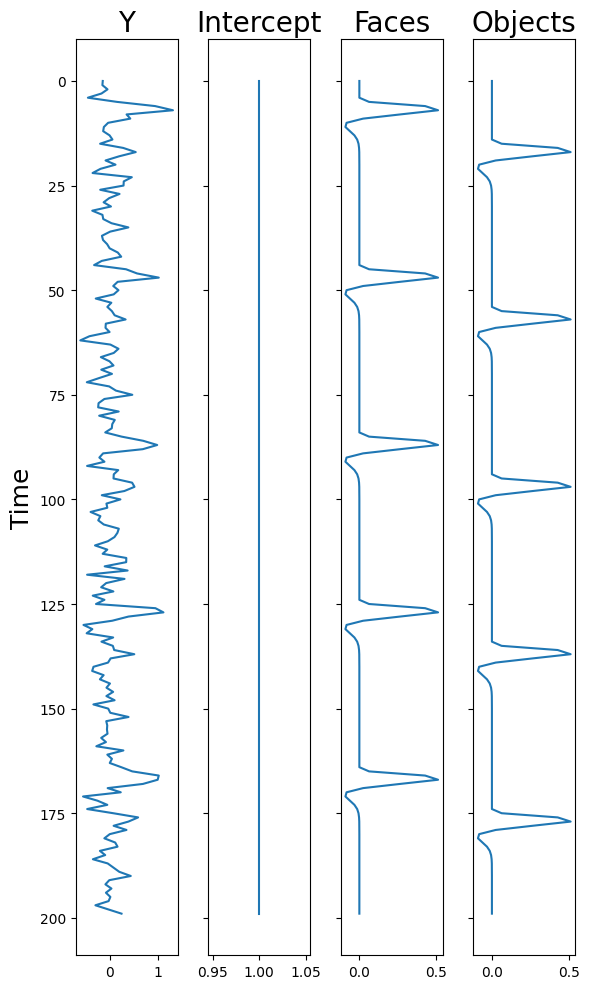

In [11]:
f, a = plt.subplots(ncols=4, figsize=(6, 10), sharey=True)
a[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
a[1].plot(X[:,0], range(len(Y)))
a[2].plot(X[:,1], range(len(Y)))
a[3].plot(X[:,2], range(len(Y)))
a[0].set_ylabel('Time', fontsize=18)
a[0].set_title('Y', fontsize=20)
a[1].set_title('Intercept', fontsize=20)
a[2].set_title('Faces', fontsize=20)
a[3].set_title('Objects', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()

## Estimate GLM

Now that have created our simulated voxel timeseries $Y$ and our design matrix $X$, we need to fit our model to the data by estimating the three $\beta$ parameters. 

There are several ways to estimate the parameters for our general linear model. The Ordinary Least Squares (OLS) estimator finds the $\hat\beta$ hyperplane that minimizes the error between the observed $Y$ and predicted $\hat Y$. 

This can be formulated using linear algebra as: 

$$\hat{\beta} = (X^T X)^{-1}X^TY$$

There is also maximum likelihood estimator, which should produce an almost identical result to the ordinary least squares estimator when the error terms are normally distributed.

$$L(\beta, \sigma^2 | Y, X) = \displaystyle \prod_{i=1}^{n}\frac{1}{\sqrt(2\pi\sigma^2)} \cdot e^{-\frac{(Y_i - \beta X_i)^2}{2\sigma^2}}$$

where 

$$\mathcal{N}(0,\sigma^{2})$$

For this class, we will primarily be focusing on the Ordinary Least Squares Estimator. In fact, just to demonstrate that the math is actually relatively straightforward, we will write our own function for the estimator using the linear algebra formulation. In practice, we typically will use a premade function, which is usually slightly more computationally efficient and will also calculate standard errors, etc.

For a more in depth overview of GLM estimation, watch this [video](https://www.youtube.com/watch?v=Ab-5AbJ8gAs) by Tor Wager and Martin Lindquist.

beta Faces - beta Objects: 1.2


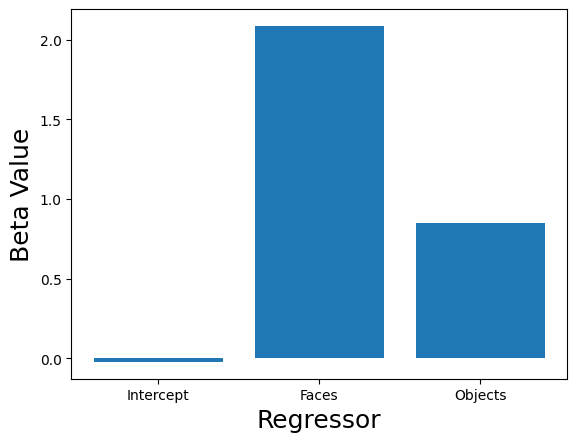

In [12]:
def ols_estimator(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

beta = ols_estimator(X, Y)

plt.bar(['Intercept','Faces', 'Objects'], beta)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print(f'beta Faces - beta Objects: {beta[1]-beta[2]:.2}')

We can see that our model is working pretty well. We did not add a mean to the simulated timeseries, so our estimator correctly figures out that the intercept parameter should be zero. The model also correctly figured out that the scaling parameter for the faces regressor was 2, and 1 for the objects regressor, with the difference between them equal to approximately 1.

Another way to evaluate how well our model is working is to plot our predicted $\hat Y$ on top of our simulated $Y$.

We can quantify the degree to which our model is accurately predicting the observed data by calculating the residual.

$$residual = Y - \hat Y$$

Text(0.5, 1.0, 'Residual')

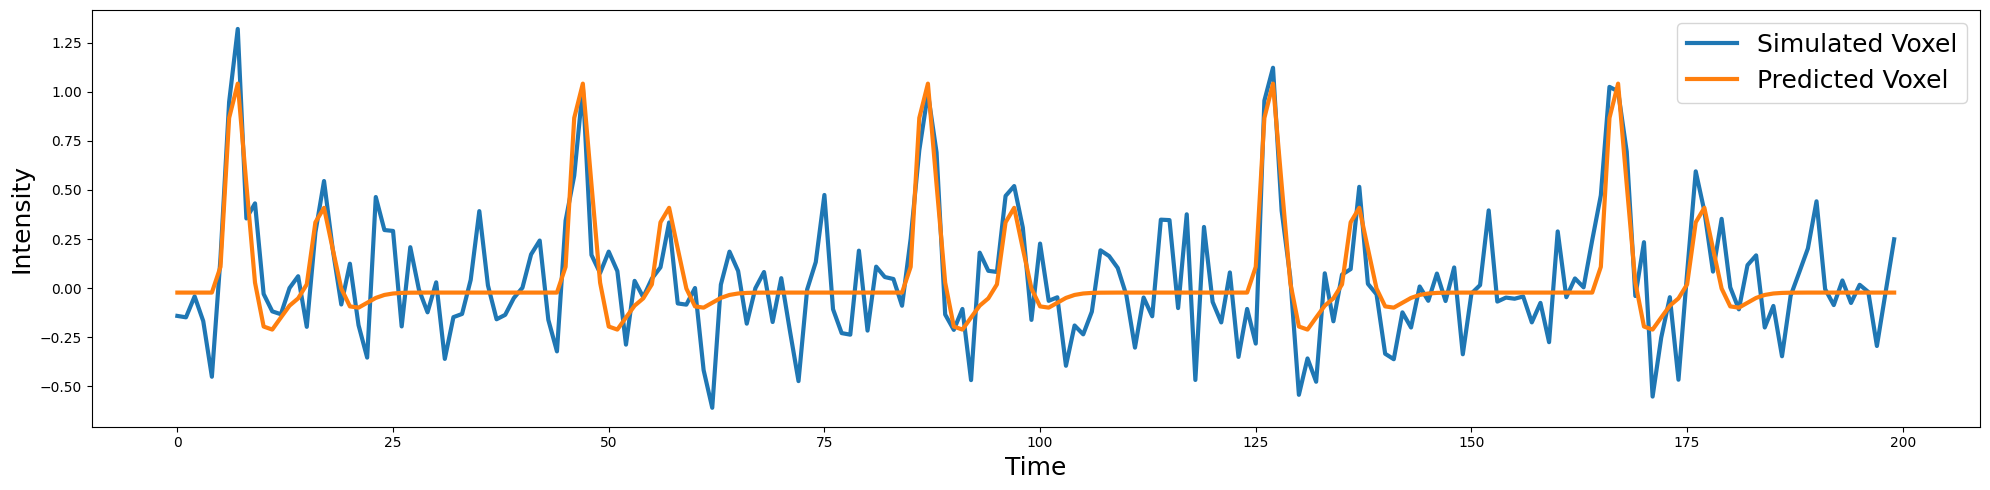

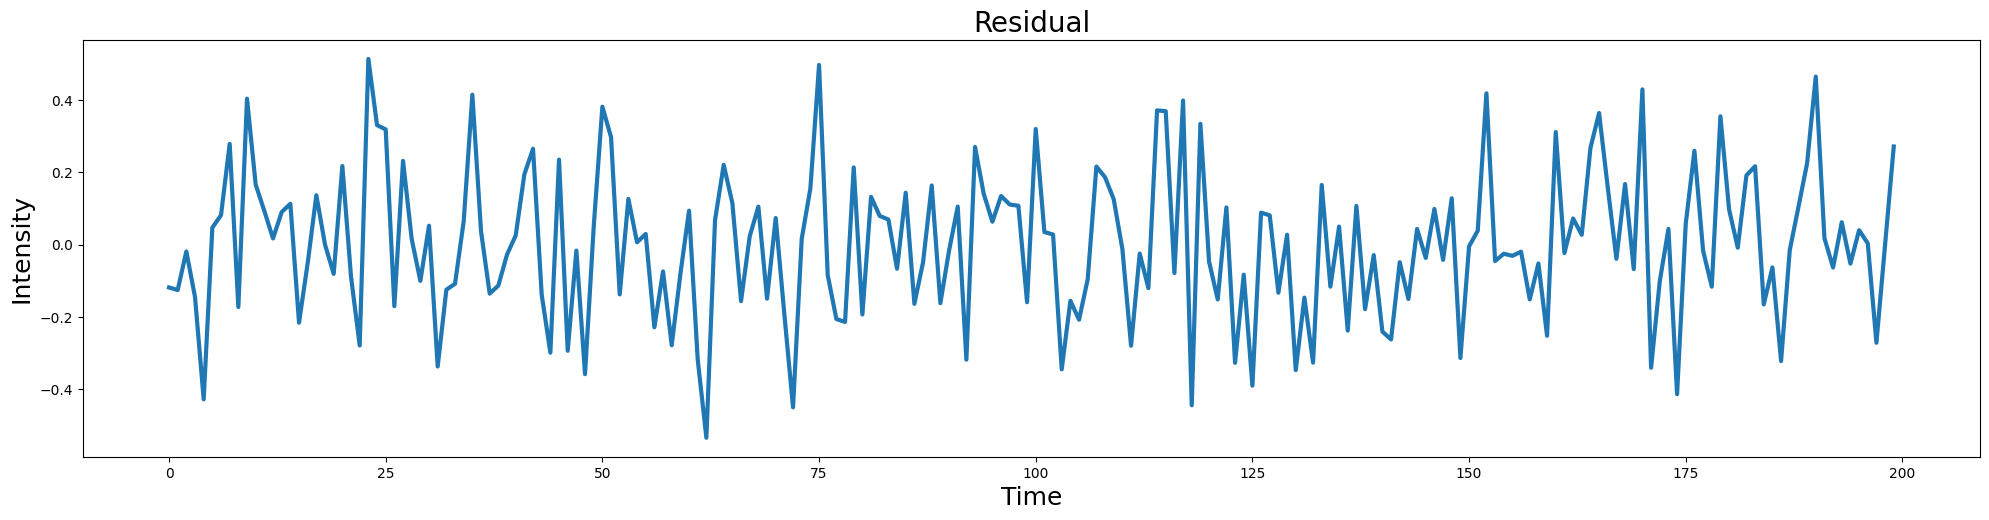

In [13]:
predicted_y = np.dot(X, beta)

predicted_ts = np.vstack([Y, predicted_y]).T

plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])

residual = Y - predicted_y

plot_timeseries(residual)
plt.title('Residual', fontsize=20)

### Standard Errors

As you can see, we are doing a reasonable job recovering the original signals.

You may recall that we specified 3 parameters in our simulation 
 - a $\beta$ weight for faces
 - a $\beta$ weight for objects
 - an $\epsilon$ noise parameter.

The *standard error of the estimate* refers to the standard deviation of the residual.

Formally, this can be described as:

$$\hat \sigma = \sqrt{\frac{\displaystyle \sum_i^n(\hat Y_i - Y_i)^2}{n-k}}$$

where $n$ is the number of observations and $k$ is the total number of regressors. 

This number is essentially an estimate of the overall amount of error in the model or $\epsilon$. This error is assumed to be independent and normally distributed. The smaller the residual variance $\hat\sigma$ the better the fit of the model.

As you can see, the parameter is close, but slightly higher than the one we simulated.  This might be because we have relatively little data in our simulation.

Standard Error of the Estimate: 0.21


Text(0.5, 0, 'Prediction Error')

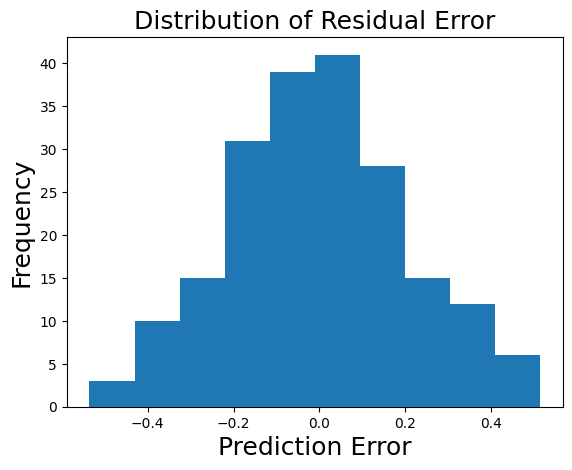

In [14]:
standard_error_of_estimate = np.std(residual)

print(f"Standard Error of the Estimate: {standard_error_of_estimate:.2}")

plt.hist(residual)
plt.title('Distribution of Residual Error', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Prediction Error', fontsize=18)

### Explained Variance

Sometimes we want a single metric to quantify overall how well our model was able to explain variance in the data. There are many metrics that can provide a quantitative measure of *goodness of fit*.

Here we will calculate $R^2$ using the following formula:

$$R^2 = 1 - \frac{\displaystyle \sum_i^n(\hat y_i - y_i)^2}{\displaystyle \sum_i^n(y_i - \bar y)^2}$$

where $y_i$ is the measured value of the voxel at timepoint $i$, $\hat y_i$ is the predicted value for time point $i$, and $\bar y$ is the mean of the measured voxel timeseries.

$R^2$ will lie on the interval between $[0,1]$ and can be interpreted as percentage of the total variance in $Y$ explained by the model, $X$, where 1 is 100% and 0 is none.

In [15]:
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

print(f"R^2: {r_square(Y, predicted_y):.2}")

R^2: 0.6


### Standard Error of $\beta$ estimates

We can also estimate the uncertainty of regression coefficients. The uncertainty of the beta parameters is quantified as a standard error around each specific estimate. 

$$\sigma = \sqrt{diag((X^TX)^{-1})} \cdot \hat \sigma$$

This is essentially a confidence interval around the $\beta_j$ estimate. One standard error, $1*\hat \sigma$ is approximately equivalent to a 68% confidence interval, while $2*\hat\sigma$ is approximately a 95% confidence interval.



Text(0, 0.5, 'Beta Value')

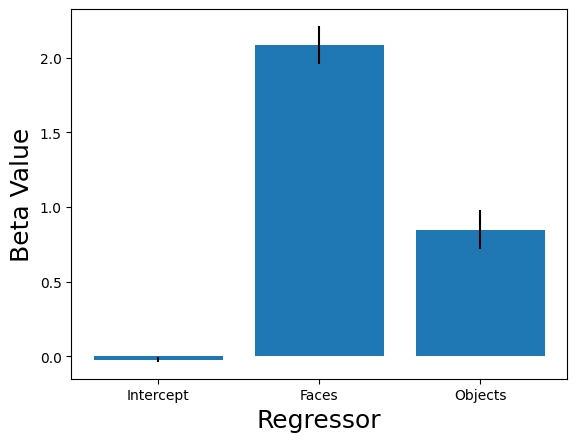

In [16]:
std_error = np.sqrt(np.diag((np.linalg.pinv(np.dot(X.T, X))))) * standard_error_of_estimate

plt.bar(['Intercept','Faces', 'Objects'], beta, yerr = std_error)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)


### Statistical Significance

We could also perform a hypothesis test to evaluate if any of the regressors are statistically different from zero.

This exercise is simply meant to provide parallels to common statistical jargon. In practice, this is actually rarely done in neuroimaging analysis as we are typically more interested in making statistical inferences across the population rather than within a single participant.

The formula for calculating a t-statistic is very simple:

$$t = \frac{\hat \beta_j}{\hat \sigma_j}$$

where $\beta_j$ refers to the estimated parameter for a regressor $j$, and $\sigma_j$ refers to the standard error of regressor $j$.

$t$ values that are more than 2 standard errors away from zero are called *statistically significant*, which basically just means we are more confident that the estimate is stable and not just an artifact of small sample size. In general, we don't recommend reading too much into significance for individual $\beta$ estimates in single subject fMRI analysis.

In [17]:
t = beta/std_error
t

array([-1.49513345, 16.16906298,  6.57947691])

Just like in intro statistics, we could find the p-value that corresponds to a particular t-statistic using the t-distribution. We will load the t distribution from `scipy.stats` and calculate the corresponding p-values using the survival function or  $1- cdf$, which requires specifying the degrees of freedom (df), which is $n-1$. We multiply these values by 2 to calculated a two-tailed test.

You can see that the intercept $\beta$ is not significant, but the face and object regressors are well below `p < 0.05`. 

[1.36463709e-01 4.20275548e-38 4.08418052e-10]


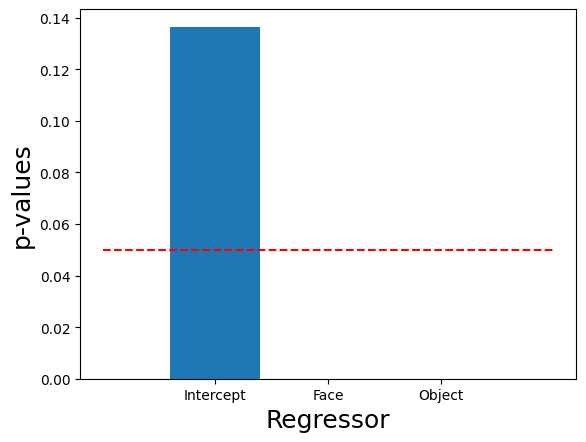

In [18]:
from scipy import stats

p = stats.t.sf(np.abs(t), n_tr-1)*2
print(p)

plt.bar(['Intercept', 'Face', 'Object'], p)
plt.ylabel('p-values', fontsize=18)
plt.xlabel('Regressor', fontsize=18)
plt.hlines(0.05, -1, 3, linestyles='dashed', color='red')

### Contrasts

Contrasts are a very important concept in fMRI data analysis as they provide the statistical inference underlying the subtraction method of making inferences. 

Let's watch a short video by Tor Wager on contrasts. We will also spend much more time on contrasts in the group analysis tutorial. We also recommend watching Jeannette Mumford's [overview](https://www.youtube.com/watch?v=yLgPpmXVVbs) of contrasts for a more statistical perspective.

In [19]:
YouTubeVideo('7MibM1ATai4')

NameError: name 'YouTubeVideo' is not defined

Contrasts describe a linear combination of variables in a regression model whose coefficients add up to zero. This allows us to flexibly compare different experimental conditions.

For example, suppose we just wanted to know the magnitude of an effect for a single condition, such as the brain response to faces. We would create a contrast code that isolates the effect size (i.e., $\beta$ estimate for the face regressor)

If our GLM, was:

$$Y = \beta_0 \cdot Intercept + \beta_1 \cdot Faces + \beta_2 \cdot Objects$$

then, the corresponding contrast code or vector for faces would be:

[0, 1, 0]

The contrast code for the object condition would be:

[0, 0, 1]

and importantly the contrast *between* the face and object condition would be:

[0, 1, -1]

More simply, we are calculating the magnitude of the effect of the difference between viewing faces and objects in a single voxel.

To make this a little bit more clear, we will show a graphical representation of the design matrix to make it obvious what we are contrasting.

{('[0, 0, 1]', 0.8486071084783933),
 ('[0, 1, -1]', 1.236844664355981),
 ('[0, 1, 0]', 2.085451772834374)}

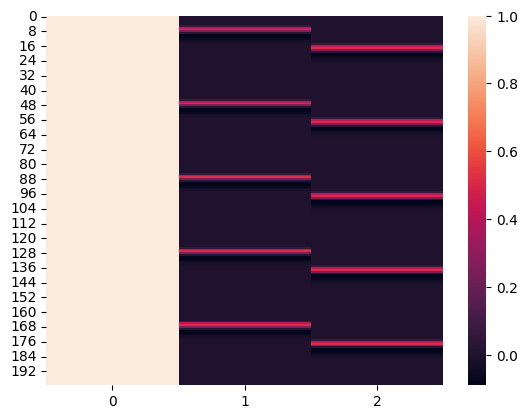

In [20]:
sns.heatmap(X)

c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]

{(str(c),np.dot(beta, c)) for c in [c1, c2, c3]}

### Efficiency

We can estimate the efficiency, or the quality of an estimator for a specific experimental design or a hypothesis testing procedure. Efficiency is related to power, or the ability to detect an effect should one exist. However, unlike power, we can estimate efficiency from our design matrix and do not actually need to know the standard error for the model (unlike with power calculations). Specifically, efficiency is defined as the inverse of the sum of the estimator variances. For a more detailed explanation and general experimental design recommendations see this [overview](http://imaging.mrc-cbu.cam.ac.uk/imaging/DesignEfficiency) by Rik Henson, or this [blog post](https://theclevermachine.wordpress.com/tag/fmri-design-efficiency/) on efficiency in experimental designs.

$$e(c\hat\beta) = \frac{1}{c(X^TX)^{-1}c^T}$$

Reducing collinearity or covariance between regressors can increase design efficiency

In [21]:
def contrast_efficiency(X, contrast):
    c = np.array(contrast)
    return 1/(np.dot(np.dot(c, np.linalg.pinv(np.dot(X.T, X))), c.T))

c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]

[contrast_efficiency(X, x) for x in [c1, c2, c3]]

[2.5536839996192415, 2.5536839996192415, 1.3465769784519137]

### Varying the Inter-Trial Interval with Jittering
All of the examples so far have used a fixed inter-trial interval. However, in real experiments it is almost always a good idea to vary the inter-trial interval using jitter. This helps to decouple the slice acquisition with the experimental design to better sample the hemodynamic response over multiple trials. In addition, this can help reduce the temporal correlation between regressors modeling events that may be sequentially dependent. For example, there may be multiple parts of a trial. For example, imagine an associative learning experiment in which a cue predicts an outcome. As the cue epoch will always temporally precede the outcome epoch, it can be beneficial to temporally decouple these epochs to reduce collinearity in the design matrix, which will increase the efficiency of the experimental design. Finally, adding jitter to the inter-trial interval may help reduce participant's ability to temporally predict when the next event will happen, which may be desireable depending on the psychological question of interest. 

Here is an example for how to add jitter to our simulated experiment.

[2.3433311937564425, 2.4474356409452525, 1.2777660910054625]

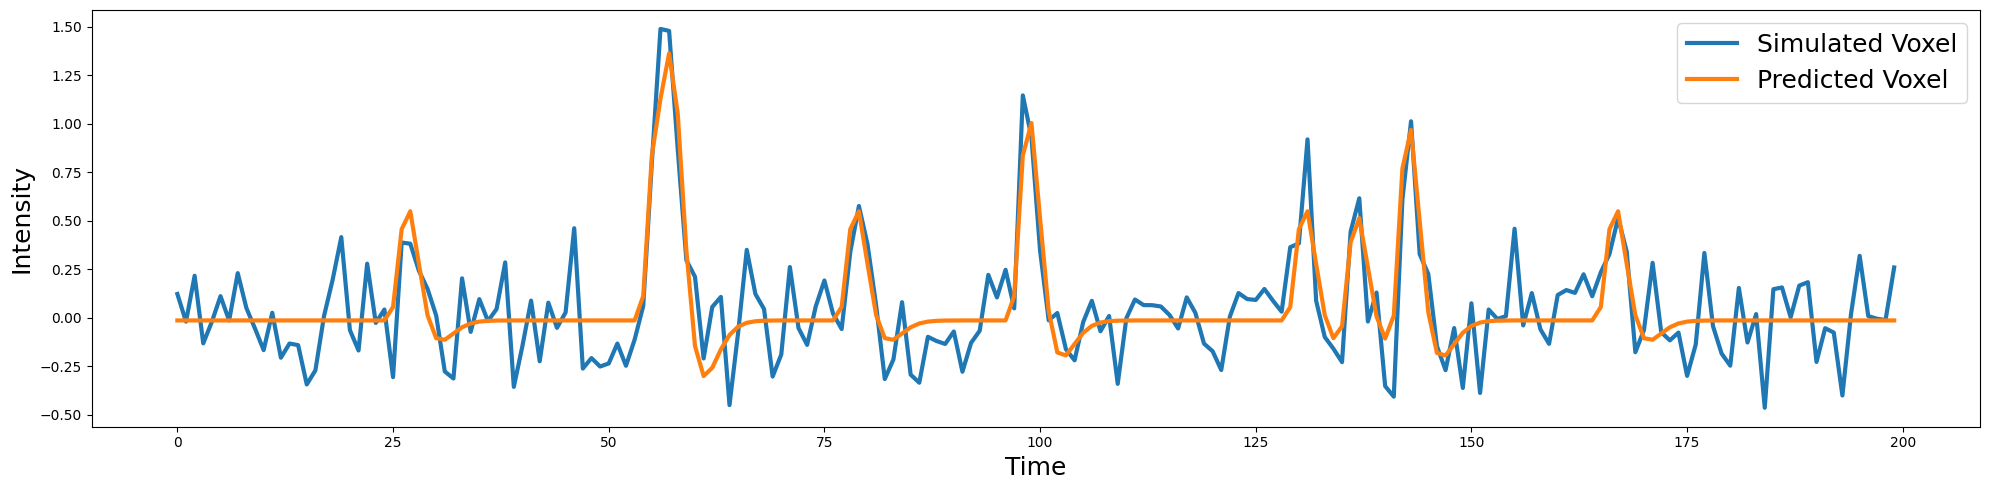

In [22]:
# Set Simulation Parameters
n_tr = 200
n_trial = 5
face_intensity = 2
object_intensity = 1
sigma = 0.15

# Build Simulation
face_trials = np.random.randint(10, 180, n_trial)
obj_trials = np.random.randint(10, 180, n_trial)
face = np.zeros(n_tr)
face[face_trials] = 1
obj = np.zeros(n_tr)
obj[obj_trials] = 1
voxel_conv = np.vstack([np.convolve(face*face_intensity, hrf, mode='same'), np.convolve(obj*object_intensity, hrf, mode='same')]).T
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

# Build Model
Y = voxel_conv_noise.sum(axis=1)
X = np.vstack([np.ones(len(face)), np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

# Estimate Model
beta = ols_estimator(X, Y)
predicted_y = np.dot(X, beta)
predicted_sigma = np.std(residual)
predicted_ts = np.vstack([Y, predicted_y]).T
plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])

# Estimate Contrast Efficiency
[contrast_efficiency(X, x) for x in [c1, c2, c3]]

### Autocorrelation

The BOLD signal has some intrinsic autocorrelation that varies with the length of the TR. Different software packages have provided varying solutions to this problem. For example, SPM implements an AR(1) model, which means that it trys to account for the fact that the signal is consistently correlated (i.e., autoregressive) with one lag. In practice, these will rarely change the beta estimates, but rather will adjust our standard errors around the estimates. As we will discuss soon, most group level analyses ignore these subject level, or first-level errors anyway. It is debatable if this is actually a good practice, but it reduces the importance of accounting for autocorrelation when looking at group level statistics in standard experimental design.

Another important thing to note is that there is some evidence that the AR(1) model can actually increase false positives, especially in shorter TRs.  See this [paper](https://www.sciencedirect.com/science/article/pii/S1053811912003825) by Anders Ekland and colleagues for more details. Also, this is a helpful [blog post](https://mandymejia.com/2016/11/06/how-to-efficiently-prewhiten-fmri-timeseries-the-right-way/) discussing prewhitening. 

For the scope of this course we will largely be ignoring this issue, but I will plan to add some examples and simulations in the future.  For now, I encourage you to watch this video on [AR models](https://www.youtube.com/watch?v=Mb9LDzvhecY&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=24) if you are interested in learning more about this topic.

## Exercises

For our homework exercises, let's use the simulation to answer questions we might have about experimental design.

### Exercise 1. What happens when we vary the signal amplitude?

Some signals will be very strong and others weaker. How does the model fit change when the signal amplitudes are stronger and weaker?

In this exercise, make a plot showing how the $r^2$ changes over 3 different levels of signal intensity.

### Exercise 2. What happens when we vary the noise?

How does the amount of noise in the data impact our model fits?  

In this exercise, make a plot showing the $r^2$ for 3 different levels of simulated noise.

### Exercise 3. How many trials do we need?

A common question in experimental design is determining the optimal number of trials.

In this exercise, try evaluating how 3 different numbers of trials might impact the contrast efficiency.

### Exercise 4. What is the impact of the stimulus duration?

What if one condition simply results in processes that systematically take longer than the other condition?

In this exercise, let's try to answer this question by creating a simulation where the signal intensity between the two condition is identical, but one simply has a longer duration (i.e., the duration has more TRs than the other condition). 

Make a plot showing what happens to the $\beta$ estimates.